# <font size="7"> **Assignment-6**</font>
I hope this assignment will give you clarity on how mathematical models like **Multilayer Perceptrons (MLP)** can be made from scratch using **PyTorch** & can be used to solve complex, non-linear geometric problems **without relying on black-box libraries**.

---
# ⚫ **Mission Critical: The Exclusion Zone Protocol**

**Date:** Year 2142  
**Location:** Exoplanet *Kepler-186f*   **Clearance:** IITians

---

### **⚫ The Story**
Humanity has colonized the distant exoplanet *Kepler-186f*. While the surface is habitable, the planet's magnetic core is unstable. The **Global Defense Council (GDC)** has identified a dangerous phenomenon known as the **"Radiation Ring."**

Sensors indicate that the safe zones on the planet follow a peculiar geometry:
* ⚫ **The Core Zone:** Distance $< 2$ km from the colony center (Safe).
* ⚫ **The Outer Wilds:** Distance $> 4$ km from the colony center (Safe).
* ⚫ **The Dead Zone:** The region **between 2 km and 4 km** is flooded with lethal gamma radiation.

Your engineering team has deployed **3,000 sensor drones** across the colony to map this danger. Each drone reports its coordinates $(x, y)$ and a binary label:
* `1`: Radiation Detected (Dead Zone)
* `0`: Safe Zone

 **⚫ The Problem:** The sensors are cheap and prone to interference. Approximately **5%** of the drones are malfunctioning and reporting the wrong safety status (noise). The GDC mainframe is a legacy system that forbids the use of modern "Neural Libraries" (i.e., you cannot use `torch.nn` or `torch.optim`). You must build a **Multi-Layer Perceptron (MLP) from scratch** to filter out the noise and mathematically define the Exclusion Zone boundaries using **PyTorch**. ( Hint: You know this is a binary classification problem, which Loss function would you use?? )

---

### **⚫ Your Objective**

1.  **Initialize the System:** Use your **Group Number** as the random seed. This ensures your team works on a unique sensor distribution pattern.
2.  **Architect the Filter:** Construct a neural network with **3 hidden layers** (16 neurons each) to learn the non-linear "donut" shape of the Dead Zone.
3.  **Manual Calibration:** You cannot use auto-optimizers. You must manually calculate the gradients (Backpropagation) and update the system weights using **Gradient Descent**.
4.  **Verify Integrity:** Split your sensor data (70% training, 30% validation). Prove that your system doesn't just memorize the malfunctioning sensors (overfitting) but actually learns the geometric shape of the Dead Zone.

---

## ⚫ Engineering Constraints (Read Carefully)

**1. Restricted Modules**
*  **Forbidden:** You are strictly forbidden from importing `torch.nn` (Layers/Loss) or `torch.optim` (Optimizers).
*  **Allowed:** `import torch`, `import matplotlib.pyplot`, `import pandas`, `import numpy`, using `sklearn`.


**2. The Mechanics**
* **Forward Pass:** Must be implemented using raw matrix multiplication (`torch.matmul`) and bias addition.
* **Backward Pass:** You **MAY** use `loss.backward()` to compute gradients automatically (Autograd).
* **Optimization:** You **MUST** implement the weight updates manually (Stochastic Gradient Descent).
    > `w_new = w_old - learning_rate * w_old.grad`

**3. Loss Function**
Since `torch.nn` is banned, you must implement **Binary Cross Entropy** manually using basic tensor math.

$$Loss = -\frac{1}{N} \sum_{i=1}^{N} [y_i \cdot \log(\hat{y}_i) + (1-y_i) \cdot \log(1-\hat{y}_i)]$$

* **Note:** Ensure you handle the log of zero (numerical stability) or use `torch.clamp` to avoid `NaN` errors.

**4. Visual Proof:** Your final output must include a Decision Boundary Map showing the "Donut" shape.


---

### ⚫ **The GDC Dashboard (Required Output)**



The Global Defense Council requires visual confirmation that your system is stable before we can upload it to the drone fleet. You must generate a **3-Panel Heads-Up Display (HUD)** containing the following telemetry:

**1. System Error Trajectory (Loss Plot)**
* **Mission:** Plot the **Training Loss** (Blue) vs. **Validation Loss** (Orange) over all epochs.
* **Why:** We need to confirm that the system is actually learning and not just diverging (exploding gradients).

**2. Integrity Check (Accuracy Plot)**
* **Mission:** Plot the **Training Accuracy** vs. **Validation Accuracy**.
* **Why:** If Training Accuracy is high (95%) but Validation Accuracy is low (80%), you have failed to generalize. This is a sign of **Overfitting**—memorizing sensor noise instead of the Radiation Ring.

**3. Geospatial Threat Map (Decision Boundary)**
* **Mission:** Visualize the **Validation Set** on a 2D map.
* **Overlay:** Draw the neural network's **Decision Boundary** (the contours where confidence = 0.5).
* **Why:** The Commander needs to *see* the "Donut" shape. If your boundary looks like a jagged mess, the model is rejected.

---

In [48]:
import torch
import numpy as np
# ===========================================================
# PART 1: Data Generation (The Exclusion Zone)
# ===========================================================

# ⚠️ INSTRUCTION: Replace 1 with your actual Group Number
GROUP_NUMBER = 9

# Set seed for reproducibility
torch.manual_seed(GROUP_NUMBER)
np.random.seed(GROUP_NUMBER)

def generate_data(n_samples=3000):
    """
    Generates 3000 sensor readings for the Kepler-186f Exclusion Zone.
    Shape: Concentric circles (Donut).
    Logic:
      - Dead Zone (1): 2km < distance < 4km
      - Safe Zone (0): distance < 2km OR distance > 4km
    """
    # Generate random coordinates between -5 and 5 km
    X = (torch.rand(n_samples, 2) * 10) - 5

    # Calculate distance from center (radius)
    radius = torch.sqrt(X[:, 0]**2 + X[:, 1]**2)

    # Assign Labels: 1 if inside the Dead Zone, 0 otherwise
    y = ((radius > 2) & (radius < 4)).float().view(-1, 1)

    # Add 5% Noise (Malfunctioning Drones)
    n_noise = int(0.05 * n_samples)
    noise_indices = torch.randperm(n_samples)[:n_noise]
    y[noise_indices] = 1 - y[noise_indices] # Flip labels

    return X, y

# Generate the dataset
X_full, y_full = generate_data(3000)

print(f"Data Generated: {X_full.shape} samples.")
print(f"Target Generated: {y_full.shape} labels.")

Data Generated: torch.Size([3000, 2]) samples.
Target Generated: torch.Size([3000, 1]) labels.


In [49]:
#@title part 2
N=X_full.shape[0] #we randomly mix all the data and split it into training and validation parts

perm=torch.randperm(N)
ts=int(0.7*N)
ti,vi=perm[:ts],perm[ts:]
X_train,y_train=X_full[ti],y_full[ti]
X_val,y_val=X_full[vi],y_full[vi]
#this helps us see if the model is actually learning or just memorizing


In [50]:
#@title part 3
def init_layer(i,o):
    W=torch.randn(i,o)*0.1
    b=torch.zeros(1,o)
    W.requires_grad=True
    b.requires_grad=True
    return W,b

W1,b1=init_layer(2,16)
W2,b2=init_layer(16,16)
W3,b3=init_layer(16,16)
W4,b4=init_layer(16,1)
params=[W1,b1,W2,b2,W3,b3,W4,b4]

def relu(x):return torch.clamp(x,min=0)
def sigmoid(x):return 1/(1+torch.exp(-x))#we manually create weight and biases for a small neural network with relu and sigmoid

def forward(x):
    x=relu(x@W1+b1)
    x=relu(x@W2+b2)
    x=relu(x@W3+b3)
    return sigmoid(x@W4+b4)#the forward function just pushes the input through all layers to get an output probability


In [51]:
#@title part 4
def binary_cross_entropy(yh,y):
    eps=1e-7
    yh=torch.clamp(yh,eps,1-eps)
    return -(y*torch.log(yh)+(1-y)*torch.log(1-yh)).mean()#binary cross entropy tells us how wrong the predictions are compared to true outcomes


def accuracy(yh,y):
    accuracy=((yh>0.5)==y).float().mean()
    print("accuracy:", accuracy.item())
    return ((yh>0.5)==y).float().mean()#accuracy checks how many predictions are correct using a simple 0.5 cutoff.


In [52]:
#@title part 5
lr=0.09
epochs=3000
tl,vl,ta,va=[],[],[],[]

for e in range(epochs):
    yh=forward(X_train)
    loss=binary_cross_entropy(yh,y_train)#the model predicts, calculates loss, backpropagates, and updates weights step by step.
    acc=accuracy(yh,y_train)
    loss.backward()

    with torch.no_grad():
        for p in params:
            p-=lr*p.grad
            p.grad.zero_()

    tl.append(loss.item())
    ta.append(acc.item())

    with torch.no_grad():
        yv=forward(X_val)
        vl.append(binary_cross_entropy(yv,y_val).item())
        va.append(accuracy(yv,y_val).item())#the model predicts,calculates loss and backpropagates and updates weights step by step

    if e%50==0:
        print(f"epoch {e} train {loss:.4f} val {vl[-1]:.4f}")


Streaming output truncated to the last 5000 lines.
accuracy: 0.6033333539962769
accuracy: 0.6123809814453125
accuracy: 0.6033333539962769
accuracy: 0.6123809814453125
accuracy: 0.6033333539962769
accuracy: 0.6123809814453125
accuracy: 0.6033333539962769
accuracy: 0.6123809814453125
accuracy: 0.6033333539962769
accuracy: 0.6123809814453125
accuracy: 0.6033333539962769
accuracy: 0.6123809814453125
accuracy: 0.6033333539962769
accuracy: 0.6123809814453125
accuracy: 0.6033333539962769
accuracy: 0.6123809814453125
accuracy: 0.6033333539962769
accuracy: 0.6123809814453125
accuracy: 0.6033333539962769
accuracy: 0.6123809814453125
accuracy: 0.6033333539962769
accuracy: 0.6123809814453125
accuracy: 0.6033333539962769
accuracy: 0.6123809814453125
accuracy: 0.6033333539962769
accuracy: 0.6123809814453125
accuracy: 0.6033333539962769
accuracy: 0.6123809814453125
accuracy: 0.6033333539962769
accuracy: 0.6123809814453125
accuracy: 0.6033333539962769
accuracy: 0.6123809814453125
accuracy: 0.603333353

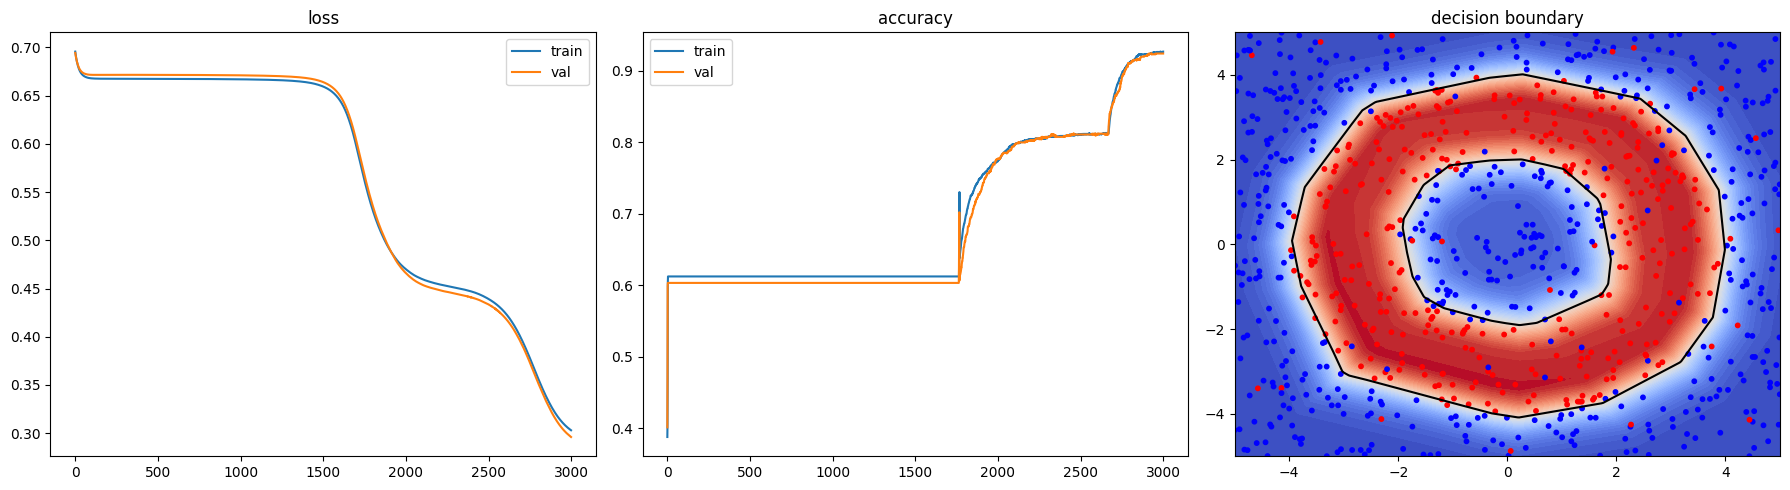

In [53]:
#@title part 6
import matplotlib.pyplot as plt
plt.figure(figsize=(18,5))

plt.subplot(1,3,1)# this is the loss trajectary graph
plt.plot(tl,label="train")
plt.plot(vl,label="val")
plt.title("loss")
plt.legend()






plt.subplot(1,3,2)# this is the accuracy trajectory plot
plt.plot(ta,label="train")
plt.plot(va,label="val")
plt.title("accuracy")
plt.legend()



xx,yy=np.meshgrid(np.linspace(-5,5,300),np.linspace(-5,5,300))
grid=torch.tensor(np.c_[xx.ravel(),yy.ravel()],dtype=torch.float32)

with torch.no_grad():
    p=forward(grid).reshape(xx.shape)

plt.subplot(1,3,3)# this is the decision boundary plot
plt.contourf(xx,yy,p.numpy(),50,cmap="coolwarm")
plt.contour(xx,yy,p.numpy(),[0.5],colors="black")
plt.scatter(X_val[:,0],X_val[:,1],c=y_val[:,0],s=10,cmap="bwr")
plt.title("decision boundary")

plt.tight_layout()
plt.show()
